# Imports

In [1]:
import torch
from tqdm.notebook import tqdm
from types import MethodType
import matplotlib.pyplot as plt

In [2]:
import matplotlib
matplotlib.rcParams['figure.facecolor'] = 'white'

In [3]:
%run ../utils/__init__.py
config_logging(logging.INFO)

# Functions

In [4]:
from collections import namedtuple

In [5]:
%run ../datasets/__init__.py

In [6]:
BalanceDistribution = namedtuple('BalanceDistribution', [
    'dataloader',
    'n_positives',
])

In [7]:
shorter_label = {
    'No Finding': 'NF',
    'Enlarged Cardiomediastinum': 'Enl Card',
    'Pleural Effusion': 'Pleural-E',
    'Pleural Other': 'Pleural-O',
    'Support Devices': 'Dev',
}

In [8]:
def plot_distributions(dist, n_rows=3, n_cols=5, bins=10):
    """Plots a balance distribution.
    
    Args:
        dataloader -- Dataloader used to calculate distributions
        n_positives -- array/tensor of shape (n_batches, n_diseases+1), with the amount of positives by batch
    """
    plt.figure(figsize=(15, 10))
    
    dataloader = dist.dataloader
    n_positives = dist.n_positives.float()
    
    labels = list(dataloader.dataset.labels) + ['No Finding']
    batch_size = dataloader.batch_size
    
    plt.suptitle(f'BS={batch_size}, SAMPLER={str(dataloader.sampler.__class__.__name__)}')

    for i_label, label_name in enumerate(labels):
        plt.subplot(n_rows, n_cols, i_label + 1)
        
        # TODO: allow plotting n_positives values across epochs,
        # i.e. plt.plot(t, n_positives[:, i_label])
        arr = n_positives[:, i_label]

        vals, _, _ = plt.hist(arr, bins=bins)
        if i_label % n_cols == 0: plt.ylabel('Frequency')
        if i_label // n_cols == n_rows - 1: plt.xlabel('Positive samples in a batch')
        

        mean_value = arr.mean()
        plt.vlines(mean_value, 0, vals.max(), color='red')
        
        label_name = shorter_label.get(label_name, label_name)
        plt.title(f'{label_name}, {mean_value:.1f}, {mean_value/batch_size*100:.1f}%')

In [9]:
def compute_average_balance(create_dataloader=prepare_data_classification, **kwargs):
    """Computes balance of labels in a dataloader.
    
    "Balance" is defined as the average amount of positive labels in a batch, per disease.
    
    Args:
        create_dataloader -- function to create the dataloader
        **kwargs -- passed to the `create_dataloader` function
    """
    dataloader = create_dataloader(**kwargs)

    n_batches = len(dataloader)
    n_labels = len(dataloader.dataset.labels)

    positives_by_label = []
    
    checked_for_monkeypatch = False

    for batch in tqdm(iter(dataloader)):
        labels = batch.labels.sum(dim=0) # shape: n_labels

        if not checked_for_monkeypatch:
            if not (batch.image == -1).all().item():
                print(f'Warning: dataset may be loading images, images={batch.image}')
            checked_for_monkeypath = True
        
        no_finding_count = batch.labels.sum(dim=1) # shape: batch_size
        no_finding_count = (no_finding_count == 0).sum().unsqueeze(0) # shape: 1
        no_finding_count = no_finding_count.type(labels.dtype)
        
        labels = torch.cat((labels, no_finding_count), dim=0) # shape: n_labels+1
        
        positives_by_label.append(labels)

    positives_by_label = torch.stack(positives_by_label, dim=0)
    # shape: n_batches, n_labels+1

    print('Amount of positives by label, in average: ', positives_by_label.float().mean(dim=0).tolist())
    stats = {
        'sampler': str(dataloader.sampler.__class__.__name__),
        'n_samples': len(dataloader.dataset),
        'n_batches': len(dataloader),
        'batch_size': dataloader.batch_size,
    }
    print(' '.join(f'{k}={v}' for k, v in stats.items()))

    return BalanceDistribution(dataloader=dataloader, n_positives=positives_by_label)

# Classification

In [10]:
%run ../datasets/__init__.py
%run ../datasets/common/__init__.py

In [11]:
# Monkey patch the method, to not load images
def getitem_labelsonly(self, idx):
    row = self.label_index.iloc[idx]
    labels = row[self.labels].to_numpy().astype('int')
    
    return BatchItem(labels=labels)

CXR14Dataset.__getitem__ = getitem_labelsonly

In [12]:
CXR_14_KWARGS = {
    'dataset_name': 'cxr14',
    'dataset_type': 'train',
}

INFO(02-01 17:57) Loading cxr14/train cl-dataset, bs=40, imgsize=(512, 512), version=None...
INFO(02-01 17:58) 	Dataset size: 75714


  0%|          | 0/1893 [00:00<?, ?it/s]

Amount of positives by label, in average:  [3.8594822883605957, 0.7871103882789612, 4.034337043762207, 6.353407382965088, 1.8906497955322266, 2.182250499725342, 0.40253564715385437, 1.244057059288025, 1.323296308517456, 0.6434231400489807, 0.6899101734161377, 0.584786057472229, 1.049656629562378, 0.0665610134601593, 23.311674118041992]
sampler=SequentialSampler n_samples=75714 n_batches=1893 batch_size=40


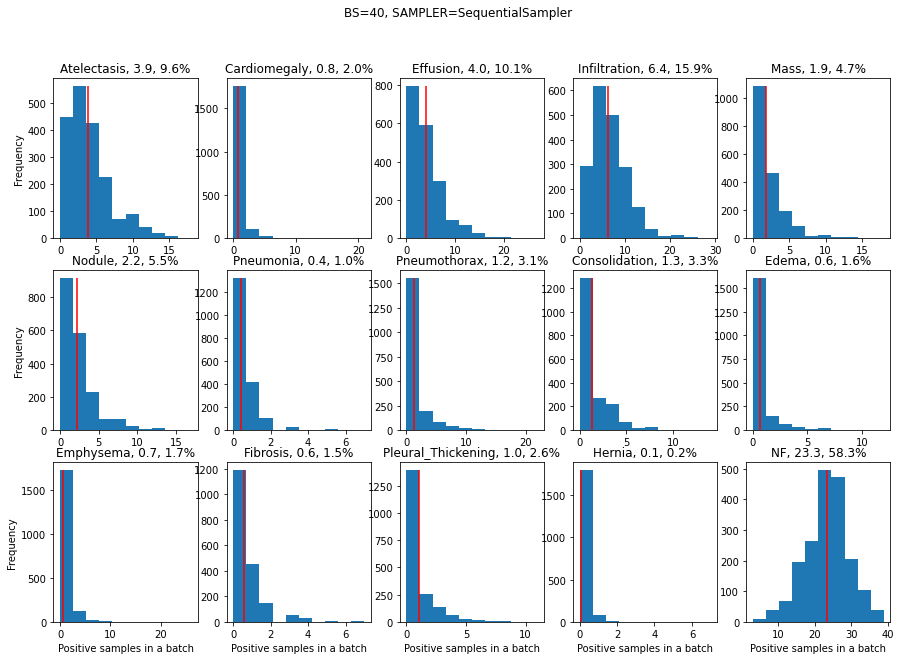

In [28]:
dist_40 = compute_average_balance(batch_size=40, **CXR_14_KWARGS)
plot_distributions(dist_40)

In [31]:
dist = dist_40

batch_size = dist.dataloader.batch_size
n_diseases = len(dist.dataloader.dataset.labels)

d = dist.n_positives
d = d.sum(axis=1) # shape: n_batches
d = d / (batch_size * n_diseases)

d

tensor([0.0929, 0.0893, 0.0821,  ..., 0.0929, 0.0804, 0.0946])

(array([708., 602., 357., 136.,  64.,  15.,   7.,   2.,   0.,   2.]),
 array([0.07142857, 0.08053572, 0.08964286, 0.09875   , 0.10785715,
        0.11696428, 0.12607142, 0.13517857, 0.14428571, 0.15339285,
        0.1625    ], dtype=float32),
 <a list of 10 Patch objects>)

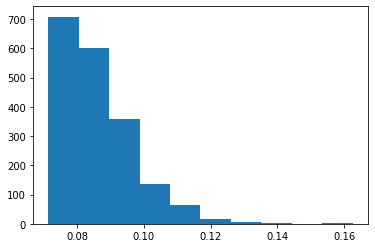

In [32]:
plt.hist(d)

INFO(02-01 17:48) Loading cxr14/train cl-dataset, bs=40, imgsize=(512, 512), version=None...
INFO(02-01 17:48) 	Dataset size: 75714
INFO(02-01 17:48) 	Multilabel balanced-sampling: samples-by-label=[7306, 1490, 7637, 12027, 3579, 4131, 762, 2355, 2505, 1218, 1306, 1107, 1987, 126, 44129] cap-max-samples=20000 new-total=300000 original=75714 times-larger=3


  0%|          | 0/7500 [00:00<?, ?it/s]

Amount of positives by label, in average:  [8.376667022705078, 3.5974667072296143, 9.632133483886719, 10.912400245666504, 5.542933464050293, 5.185333251953125, 3.3553333282470703, 4.290666580200195, 4.716133117675781, 3.7923998832702637, 3.660933256149292, 3.4410667419433594, 4.395066738128662, 2.7435998916625977, 2.6666667461395264]
sampler=MultilabelBalancedSampler n_samples=75714 n_batches=7500 batch_size=40


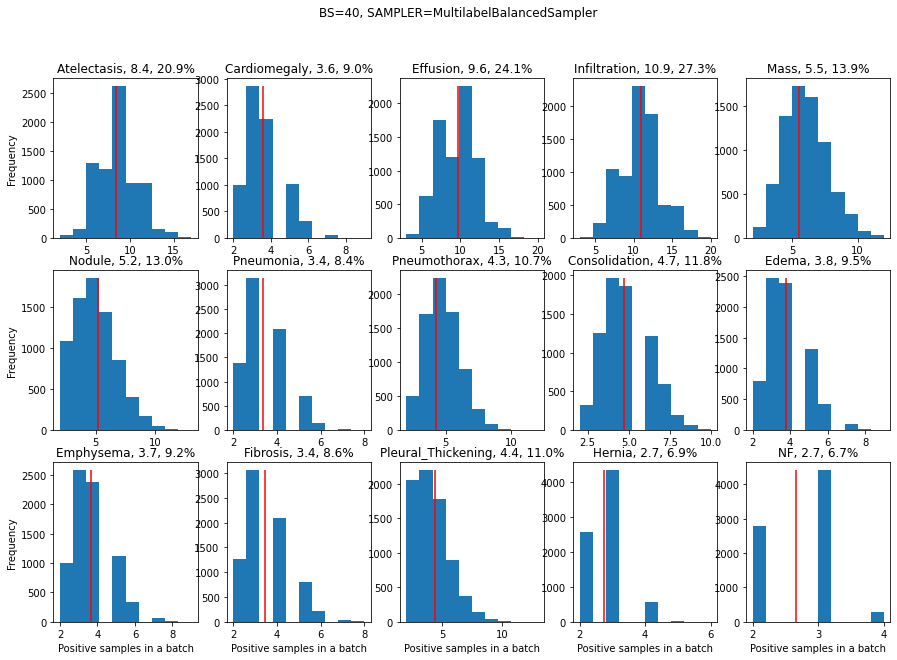

In [13]:
dist_40_balanced = compute_average_balance(batch_size=40, balanced_sampler=True, **CXR_14_KWARGS)
plot_distributions(dist_40_balanced)

In [14]:
batch = next(iter(dist_40_balanced.dataloader))

In [15]:
batch.labels

tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0],
        [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
        [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0],
        [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0],
        [0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
        [0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0],
        [0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0],
        [1, 

In [30]:
dist = dist_40_balanced

batch_size = dist.dataloader.batch_size
n_diseases = len(dist.dataloader.dataset.labels)

d = dist.n_positives
d = d.sum(axis=1) # shape: n_batches
d = d / (batch_size * n_diseases)

(d < 0.5).sum()

tensor(7500)

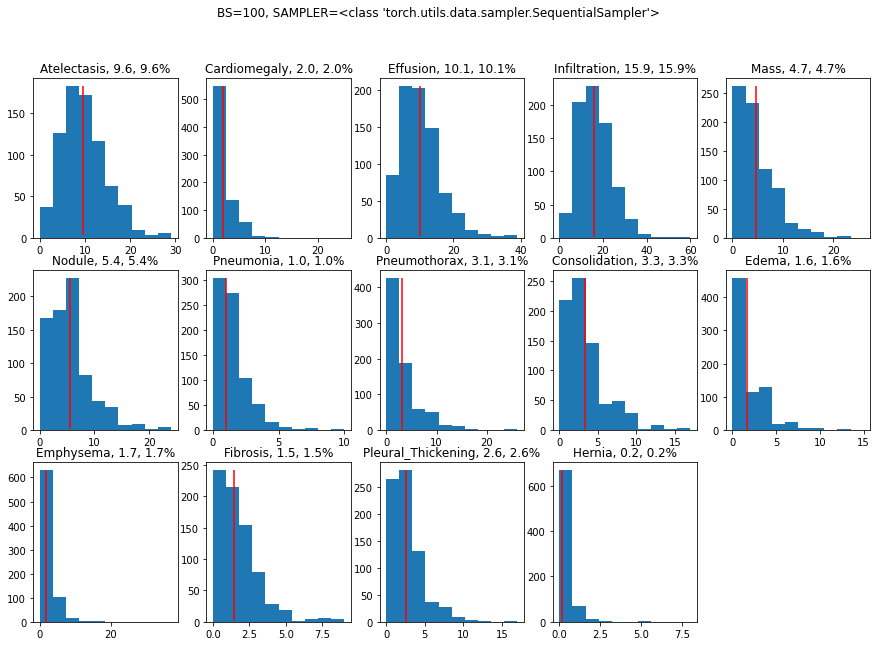

In [138]:
# dist_100 = compute_average_balance(batch_size=100, **CXR_14_KWARGS)
plot_distributions(dist_100, 100)

Loading cxr14/train dataset...
	Oversampling Atelectasis: os-class=1 ratio=9 positives=7306 negatives=68408 new-total=134162 original=75714



Amount of positives by label, in average:  tensor([19.5988,  0.8352,  6.7162,  8.0271,  2.1040,  2.1159,  0.5967,  1.5246,
         2.3347,  0.6754,  0.9639,  0.7210,  1.2790,  0.1043])
Batch size:  40


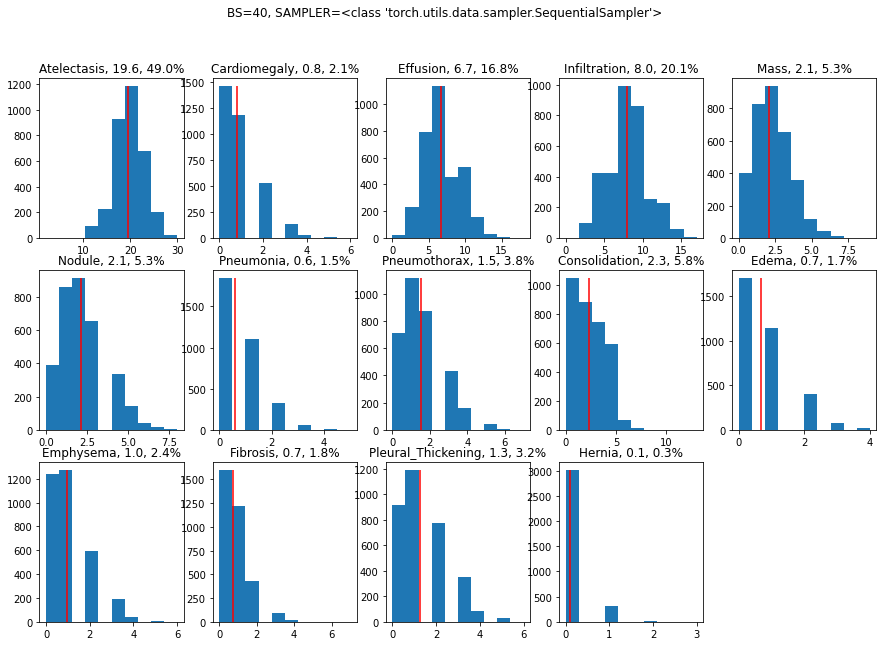

In [139]:
bs = 40
dist_40_os = compute_average_balance(batch_size=bs, oversample=True, **CXR_14_KWARGS)
plot_distributions(dist_40_os, bs)

Loading cxr14/train dataset...
	Oversampling Cardiomegaly: os-class=1 ratio=49 positives=1490 negatives=74224 new-total=147234 original=75714



Amount of positives by label, in average:  tensor([ 4.1233, 19.8343,  9.1163,  6.5143,  1.6895,  1.8655,  0.4026,  0.8745,
         1.4238,  0.9829,  0.6808,  0.6398,  1.3613,  0.0994])
Batch size:  40


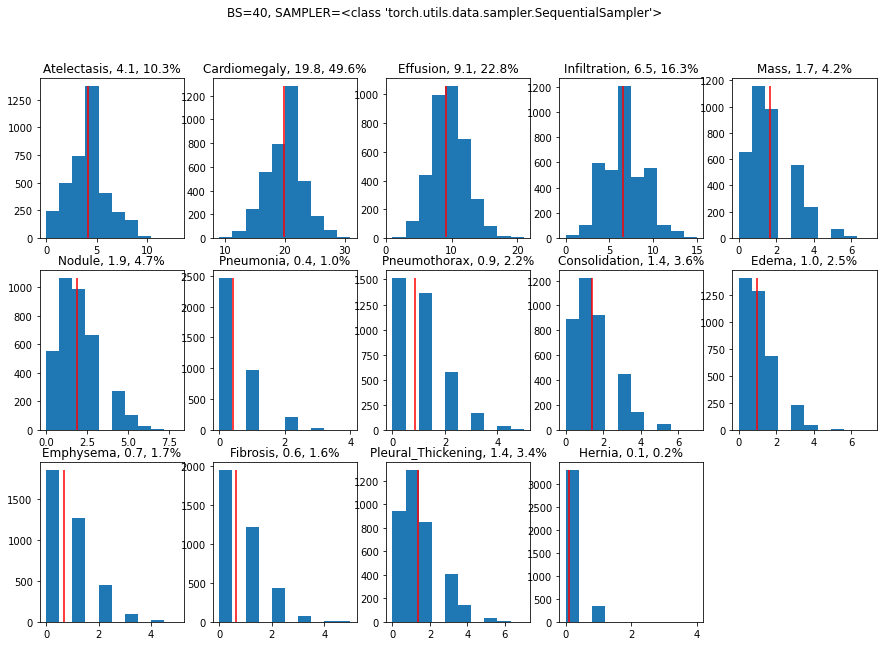

In [140]:
bs = 40
dist = compute_average_balance(batch_size=bs,
                                     oversample=True,
                                     oversample_label=1,
                                     **CXR_14_KWARGS)
plot_distributions(dist, bs)

# Report generation

In [8]:
from functools import partial

In [9]:
%run ../datasets/__init__.py
%run ../datasets/common/__init__.py
%run ../training/report_generation/flat.py

In [10]:
def getitem_ignoreimages(self, idx):
    report = self.reports[idx]
    filename = report['filename']
    labels = self.labels_by_report[filename]
    
    return BatchItem(labels=labels, report=report['tokens_idxs'], image=torch.tensor(-1))

IUXRayDataset.__getitem__ = getitem_ignoreimages

### Classification-wise (i.e. labels)

In [12]:
IU_KWARGS = {
    'dataset_name': 'iu-x-ray',
    'dataset_type': 'train',
#     'create_dataloader': partial(
#         prepare_data_report_generation,
#         create_dataloader_fn=create_flat_dataloader,
#     ),
}

  0%|          | 0/593 [00:00<?, ?it/s]

Amount of positives by label, in average:  tensor([4.0017, 1.0135, 1.6121, 0.4503, 1.8718, 0.1602, 0.1653, 0.1433, 0.7066,
        0.1315, 0.4132, 0.1282, 0.3187, 0.5801, 1.6391])
Batch size:  10


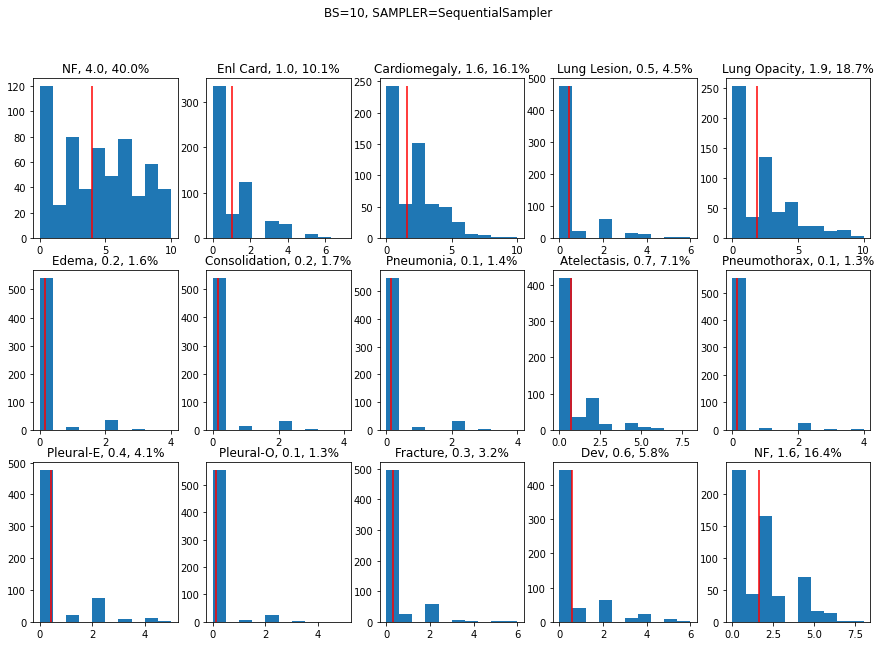

In [15]:
dist_10 = compute_average_balance(batch_size=10, **IU_KWARGS)
plot_distributions(dist_10)

### Sentences

In [33]:
import os
from collections import Counter, defaultdict
import numpy as np
import pandas as pd

In [19]:
%run ../utils/nlp.py
%run ../datasets/common/constants.py

In [124]:
dataloader = prepare_data_report_generation(create_flat_dataloader,
                                            dataset_name='iu-x-ray',
                                            dataset_type='train',
                                            batch_size=20,
                                            shuffle=True,
                                           )
len(dataloader.dataset)

5923

#### Load stuff to get sentences labels

In [38]:
fpath = os.path.join(dataloader.dataset.reports_dir, 'sentences_with_chexpert_labels.csv')
sentence_labels_df = pd.read_csv(fpath, index_col='sentences')
sentence_labels_df = sentence_labels_df[CHEXPERT_LABELS]
sentence_labels_df.replace(-1, 1, inplace=True)
sentence_labels_df.replace(-2, 0, inplace=True)
sentence_labels_df.head()

,No Finding,Enlarged Cardiomediastinum,Cardiomegaly,Lung Lesion,Lung Opacity,Edema,Consolidation,Pneumonia,Atelectasis,Pneumothorax,Pleural Effusion,Pleural Other,Fracture,Support Devices
sentences,,,,,,,,,,,,,,
the cardiac silhouette and mediastinum size are within normal limits .,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
there is no pulmonary edema .,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
there is no focal consolidation .,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
there are no xxxx of a pleural effusion .,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
there is no evidence of pneumothorax .,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [39]:
sentence_to_labels = sentence_labels_df.transpose().to_dict(orient='list')
sentence_to_labels

{'the cardiac silhouette and mediastinum size are within normal limits .': [1.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0],
 'there is no pulmonary edema .': [1.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0],
 'there is no focal consolidation .': [1.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0],
 'there are no xxxx of a pleural effusion .': [1.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0],
 'there is no evidence of pneumothorax .': [1.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0],
 'the cardiomediastinal silhouette is within normal limits for size and contour .': [1.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0],
 'the lungs are normally inflated without evidence of focal airspace disease , pleural effus

In [21]:
report_reader = ReportReader(dataloader.dataset.get_vocab())

#### Evaluate in dataloader

In [125]:
different_sentences_per_batch = []
errors = defaultdict(list)

labels_by_batch = []

for batch in tqdm(iter(dataloader)):
    sentences_counter = Counter()
    batch_labels = np.zeros(len(CHEXPERT_LABELS) + 1)
    
    for report in batch.reports:
        for sentence in sentence_iterator(report):
            
            sentence = report_reader.idx_to_text(sentence)
            
            # Count sentences
            sentences_counter[sentence] += 1
            
            # Count labels
            labels = sentence_to_labels.get(sentence, None)
            if labels is None:
                errors['no-labels-found'].append(sentence)
                continue
            no_finding = int(all(l == 0 for l in labels[1:-1]))
            labels = np.array(labels + [no_finding]) # shape: n_diseases + 1
            
            batch_labels += labels

    # Accumulate labels
    labels_by_batch.append(batch_labels)

    # Count sentences
    n_sentences_in_batch = len(sentences_counter)
    different_sentences_per_batch.append(n_sentences_in_batch)

labels_by_batch = np.array(labels_by_batch) # shape: n_batches, (n_diseases+1)

# Move NF to the first label
labels_by_batch[:,0] = labels_by_batch[:,-1]
labels_by_batch = np.delete(labels_by_batch, -1, 1) # shape: n_batches, n_diseases

n_errors = {k:len(v) for k, v in errors.items()}

n_errors, np.mean(different_sentences_per_batch), labels_by_batch.shape

  0%|          | 0/297 [00:00<?, ?it/s]

({}, 83.21548821548822, (297, 14))

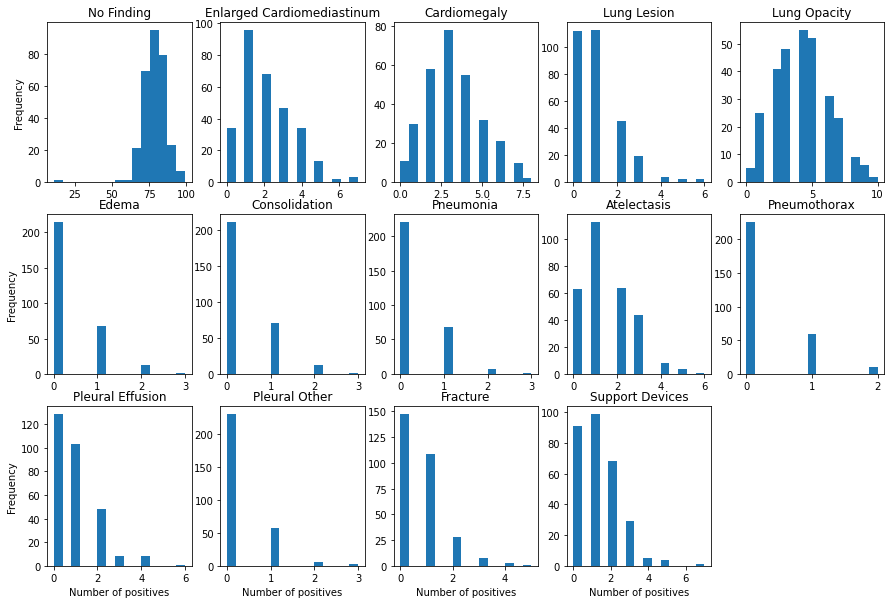

In [126]:
bins = 15

n_rows = 3
n_cols = 5

# fig, ax = plt.subplots(figsize=(15,10), sharex=True)
plt.figure(figsize=(15, 10))

for i_label, label_name in enumerate(CHEXPERT_LABELS):
    subplot_i = i_label + 1
    plt.subplot(n_rows, n_cols, subplot_i)
        
    plt.hist(labels_by_batch[:, i_label], bins=bins)
    plt.title(label_name)
    if i_label % n_cols == 0:
        plt.ylabel('Frequency')
    
    if i_label // n_cols == n_rows - 1:
        plt.xlabel('Number of positives')

In [82]:
labels_by_batch[:, 1:].sum(axis=1)

array([ 0.,  2.,  2.,  7.,  1.,  0.,  4.,  2.,  3., 11., 12.,  0.,  4.,
        2.,  8.,  2.,  6., 13.,  3.,  2.,  0.,  2.,  5.,  6.,  4.,  2.,
       11.,  6.,  9.,  2.,  4.,  2.,  4.,  2.,  4., 10.,  2., 18., 18.,
        4., 10., 20., 11.,  7.,  3., 11., 12.,  8.,  9.,  4.,  2.,  4.,
        3.,  6., 12., 14.,  8., 16.,  9., 10., 11., 14., 14., 12.,  3.,
       10.,  2., 10., 14.,  2., 12.,  6.,  5., 12.,  7.,  4., 14., 10.,
       10., 10., 12.,  0.,  4.,  6., 14.,  4.,  4.,  8., 12.,  5.,  4.,
        4.,  6.,  5.,  4.,  4.,  2.,  3.,  8.,  5., 14.,  9., 13., 17.,
        8., 15.,  9., 15., 15.,  2.,  6., 11., 10.,  4.,  2., 15., 10.,
       14., 10., 12.,  2.,  6.,  6., 10., 17., 14., 19., 14.,  5., 14.,
       12.,  7., 25.,  8., 12., 13., 21., 11.,  7., 21.,  7., 12.,  8.,
       20., 10., 21., 11.,  0.,  7., 26., 24., 24., 36., 12.,  4.,  4.,
       10., 10.,  3., 10., 12., 20., 12., 10., 12., 24., 26., 17.,  9.,
        8., 18., 12.,  8., 11.,  2.,  4.,  4., 12.,  2.,  9., 10

#### Manual inspection

In [116]:
dataloader = prepare_data_report_generation(create_flat_dataloader,
                                            dataset_name='iu-x-ray',
                                            dataset_type='train',
                                            batch_size=20,
                                            shuffle=True,
                                           )
len(dataloader.dataset)

5923

In [117]:
d = iter(dataloader)

In [123]:
reports = [
    report_reader.idx_to_text(r)
    for r in next(d).reports
]
reports

['clear lungs . no discrete adenopathy or significant scarring . no active pulmonary disease . END PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD',
 'the heart is normal in size . the mediastinum is unremarkable . there is again biapical scarring . small stable calcified left lower lobe granuloma . the lungs are otherwise clear . END PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD',
 'the trachea is midline . cardiomediastinal silhouette is normal . the lungs are clear without evidence of acute infiltrate or effusion . there is no pneumothorax . the visualized bony structu

Text(0, 0.5, 'Different sentences')

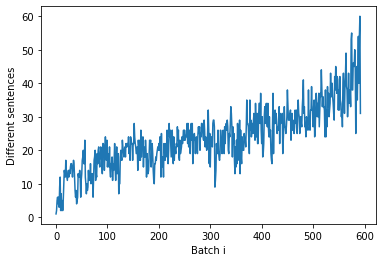

In [36]:
t = range(len(different_sentences_per_batch))
plt.plot(t, different_sentences_per_batch)

plt.xlabel('Batch i')
plt.ylabel('Different sentences')

TODO:
* for each sentence, search its labels in sentences_with_chexpert_labels.csv
* Make a plot of labels seen through the batches (i.e. labels!=NF vs batch_i)

* Same can be done by report (use dataset.labels_by_report)

In [ ]:
n_batches = len(dataloader)
n_labels = len(dataloader.dataset.labels)

positives_by_label = []

checked_for_monkeypatch = False

for batch in tqdm(iter(dataloader)):
    labels = batch.labels.sum(dim=0) # shape: n_labels

    if not checked_for_monkeypatch:
        if not (batch.image == -1).all().item():
            print(f'Warning: dataset may be loading images, images={batch.images}')
        checked_for_monkeypath = True

    no_finding_count = batch.labels.sum(dim=1) # shape: batch_size
    no_finding_count = (no_finding_count == 0).sum().unsqueeze(0) # shape: 1
    no_finding_count = no_finding_count.type(labels.dtype)

    labels = torch.cat((labels, no_finding_count), dim=0) # shape: n_labels+1

    positives_by_label.append(labels)

positives_by_label = torch.stack(positives_by_label, dim=0)
# shape: n_batches, n_labels+1

print('Amount of positives by label, in average: ', positives_by_label.float().mean(dim=0))
print('Batch size: ', dataloader.batch_size)
